In [1]:
import itertools
import os
import numpy as np
import pandas as pd
import sqlite3 as sql

import matplotlib.pyplot as plt

# Create Example Database

## Generate Data

## Create DB

In [2]:
con = sql.connect('example.db')
cur = con.cursor()

## Insert generated data

# Different Visualisations

## Default player statistics

Here I defind given player's winrate by defferent roles.

In [3]:
def get_player_answers(cur, username):
    """
    Returns table of player with given username results grouped by his answers
    
    Parameters:
    -----------
    cur : sqlite3 cursor
        Cursor to the given database.
        
    username : string from table Players.username
        Username of given player.
    
    Returns:
    --------
    res : dict
        Keys are answers, values are count numbers
    """
    query = f"""SELECT Records.role AS answer, COUNT(*) AS count
                FROM Records
                INNER JOIN Players ON Players.id = Records.player_id
                WHERE Players.username = '{username}'
                GROUP BY Records.role;"""
    res = cur.execute(query).fetchall()
    res = {i[0] : i[1] for i in res}
    for key in ['HC', 'HD', 'HL', 'HW', 'FL', 'LL', 'LW', 'FW']:
        try:
            res[key]
        except KeyError:
            res.update({key : 0})
    return res

In [4]:
def get_player_answers(cur, username):
    """
    Returns table of player with given username results grouped by his answers
    
    Parameters:
    -----------
    cur : sqlite3 cursor
        Cursor to the given database.
        
    username : string from table Players.username
        Username of given player.
    
    Returns:
    --------
    res : dict
        Keys are answers, values are count numbers
    """
    query = f"""SELECT Records.role AS answer, COUNT(*) AS count
                FROM Records
                INNER JOIN Players ON Players.id = Records.player_id
                WHERE Players.username = '{username}'
                GROUP BY Records.role;"""
    res = cur.execute(query).fetchall()
    res = {i[0] : i[1] for i in res}
    for key in ['HC', 'HD', 'HL', 'HW', 'FL', 'LL', 'LW', 'FW']:
        try:
            res[key]
        except KeyError:
            res.update({key : 0})
    return res

In [5]:
username = cur.execute("SELECT username FROM players;").fetchone()[0]
username

'@lUuwn'

In [6]:
def drow_username_winrate(cur, username, ax=None):
    """
    Plots a winrate statistics for given player.
    
    Parameters:
    -----------
    cur : sqlite3 cursor
        Cursor to the given database.
        
    username : string from table Players.username
        Username of given player.
    
    ax : matplotlib axes object, default None
        An axes of the current figure
    """
    info = get_player_answers(cur, username)
    bins = pd.DataFrame([[info['LW'], info['LL']], 
                         [info['FW'], info['FL']], 
                         [info['HC'] + info['HW'], info['HD'] + info['HL']]], 
                        columns=['Wins', 'Loses'], 
                        index=['Liberal', 'Fascist', 'Hitler']).transpose()
    
    bins.plot(kind='bar', stacked=True, color=['deepskyblue', 'orangered', 'darkred'], rot='horizontal', ax=ax)

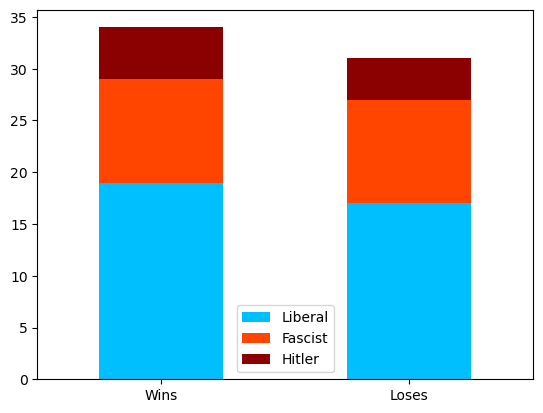

In [7]:
drow_username_winrate(cur, username)

## Best&worst players

Hare I try to define functions drowing stats with best and worst teammates opponents

In [8]:
def get_players_stats(cur, order='DESC', top=None):
    """
    Returns table containing number of wins and loses for each role and winrate
    
    Parameters:
    -----------
    cur : sqlite3 cursor
        Cursor to the given database.
        
        
    order : str values 'DESC' or 'ASC'
    
    top : uint or None
        function returns top number of results, if that's not None  
    
    Retuens:
    --------
    res : DataFrame
        Columns: username, 
                 LW (liberal wins), 
                 FW (fascist wins), 
                 HW (Hitler wins), 
                 LL (liberal loses), 
                 FL (fascist loses), 
                 HL (Hitler loses), 
                 winrate
    """
    query = f"""SELECT username,
            SUM(CASE WHEN role = 'LW' THEN 1 ELSE 0 END) AS LW,
            SUM(CASE WHEN role = 'FW' THEN 1 ELSE 0 END) AS FW,
            SUM(CASE WHEN role IN ('HW', 'HC') THEN 1 ELSE 0 END) AS HW,
            SUM(CASE WHEN role = 'LL' THEN 1 ELSE 0 END) AS LL,
            SUM(CASE WHEN role = 'FL' THEN 1 ELSE 0 END) AS FL, 
            SUM(CASE WHEN role IN ('HL', 'HD') THEN 1 ELSE 0 END) AS HL,
            AVG(CASE WHEN role IN ('LW', 'FW', 'HW', 'HC') THEN 1 ELSE 0 END) AS winrate
            FROM records
            INNER JOIN players ON players.id = records.player_id
            GROUP BY player_id ORDER BY winrate {order};"""
    if top is not None:
        query = query[:-1] + f'\nLIMIT {top};'
    res = cur.execute(query).fetchall()
    res = pd.DataFrame(res, columns=['username', 'LW', 'FW', 'HW', 'LL', 'FL', 'HL', 'winrate'])
    return res

In [9]:
df = get_players_stats(cur, top=4)
df

,username,LW,FW,HW,LL,FL,HL,winrate
0,@KvbOP,17,8,8,10,5,0,0.687500
1,@nesHu,19,10,2,11,5,4,0.607843
2,@itmfR,21,9,5,14,7,3,0.593220
3,@zbfeU,27,7,3,18,6,4,0.569231


In [10]:
def draw_topest_players(cur, n=4, best=True, normolize=True, ax=None):
    """
    Draw hists for top best or worst players by winrate
    
    Parameters:
    -----------
    cur : sqlite3 cursor
        Cursor to the given database.
        
    n : int
        Number of players
    
    best : bool
        If True, draws best players
        If False, draws worst players
        
    normolize : bool
        Normolize values to sum be 1 for each player
    
    ax : matplotlib axes object, default None
        An axes of the current figure
    """
    order = {True: "DESC", False: "ASC"}[best]
    df = get_players_stats(cur, order=order, top=n).iloc[::-1]
    df.index = df['username']
    df = df[['LW', 'FW', 'HW', 'LL', 'FL', 'HL']]
    df.columns = ['Liberal wins', 'Fascist wins', 'Hitler wins',
                  'Liberal loses', 'Fascist loses', 'Hitler loses']
    if normolize:
        df = df.transpose()
        df = df / df.sum()
        df = df.transpose()
    df.plot(kind='barh', stacked=True, color=['deepskyblue', 'orangered', 'darkred', 
                                              'lightblue', 'lightpink', 'rosybrown'], ax=ax, ylabel='')

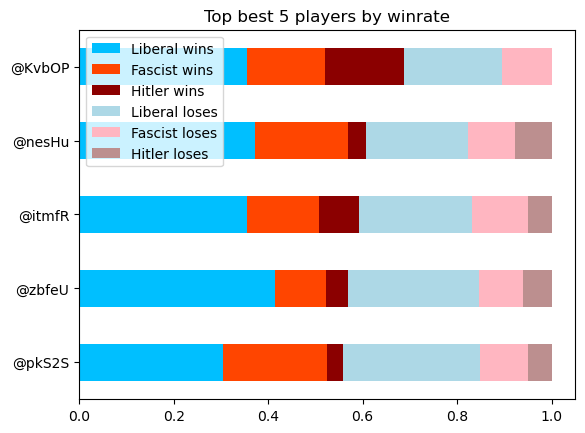

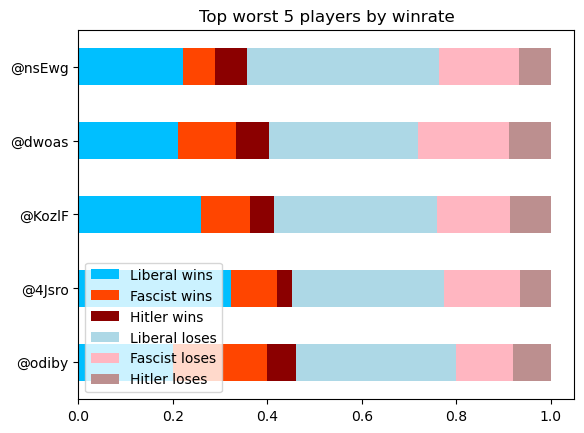

In [11]:
n = 5
fig, ax = plt.subplots()
ax.set_title(f'Top best {n} players by winrate')
draw_topest_players(cur, n, best=True, ax=ax, normolize=True)


fig, ax = plt.subplots()
ax.set_title(f'Top worst {n} players by winrate')
draw_topest_players(cur, n, best=False, ax=ax, normolize=True)


## Best&worst teammates&opponents

Hare I try to define functions drowing stats with best and worst teammates opponents

In [12]:
def get_teammate_stats(cur, username):
    """
    Returns table of counts wins and loses in both teames for each player's teammate
    
    Parameters:
    -----------
    cur : sqlite3 cursor
        Cursor to the given database.
        
    username : string from table Players.username
        Username of given player.
        
    Retuens:
    --------
    res : DataFrame
        Indexes are usernames,
        Columns are team and win stasuses
    """
    query = f"""WITH w1(record_id, game_id, player_id, win, liberal) AS 
                (SELECT id, game_id, player_id, role IN ('HC', 'HW', 'FW', 'LW'), role IN ('LL', 'LW') FROM records), 
                w2(game_id, player_liberal) AS 
                (SELECT records.game_id, records.role IN ('LL', 'LW') FROM records 
                INNER JOIN players ON players.id = records.player_id WHERE players.username="{username}")
                SELECT players.username,
                SUM(CASE WHEN w1.win AND w1.liberal THEN 1 ELSE 0 END) AS LW, 
                SUM(CASE WHEN w1.win AND NOT w1.liberal THEN 1 ELSE 0 END) AS FW, 
                SUM(CASE WHEN NOT w1.win AND w1.liberal THEN 1 ELSE 0 END) AS LL, 
                SUM(CASE WHEN NOT w1.win AND NOT w1.liberal THEN 1 ELSE 0 END) AS FL FROM w1
                INNER JOIN w2 ON w1.game_id = w2.game_id
                INNER JOIN players ON w1.player_id = players.id
                WHERE players.username != "{username}" AND w1.liberal = w2.player_liberal
                GROUP BY player_id;"""
    res = cur.execute(query).fetchall()
    res = pd.DataFrame(res, columns=['username', 'LW', 'FW', 'LL', 'FL'])
    return res

In [13]:
df = get_teammate_stats(cur, username)
df['Total'] = df[['LW', 'FW', 'LL', 'FL']].sum(axis=1)
df['Winrate'] = (df['LW'] + df['FW']) / df['Total']
df = df.sort_values(by=['Winrate', 'Total'], ascending=False)
df

,username,LW,FW,LL,FL,Total,Winrate
16,@yzxnw,2,2,1,0,5,0.800000
0,@gjECr,5,0,1,1,7,0.714286
14,@uic3A,7,2,2,2,13,0.692308
2,@KvbOP,3,3,2,1,9,0.666667
13,@zbfeU,5,1,2,1,9,0.666667
18,@dwoas,3,0,2,0,5,0.600000
8,@ytnfB,2,2,0,3,7,0.571429
9,@pkS2S,2,2,1,2,7,0.571429
6,@c6wgU,3,2,3,1,9,0.555556
10,@SxpbF,5,0,2,2,9,0.555556


In [14]:
def get_opponent_stats(cur, username):
    """
    Returns table of counts wins and loses in both opponent for each player's teammate
    
    Parameters:
    ------
    cur : sqlite3 cursor
        Cursor to the given database.
        
    username : string from table Players.username
        Username of given player.
        
    Retuens:
    --------
    res : DataFrame
        Indexes are usernames,
        Columns are team and win stasuses
    """
    query = f"""WITH w1(record_id, game_id, player_id, win, liberal) AS 
                (SELECT id, game_id, player_id, role IN ('HC', 'HW', 'FW', 'LW'), role IN ('LL', 'LW') FROM records), 
                w2(game_id, player_liberal) AS 
                (SELECT records.game_id, records.role IN ('LL', 'LW') FROM records 
                INNER JOIN players ON players.id = records.player_id WHERE players.username="{username}")
                SELECT players.username,
                SUM(CASE WHEN w1.win AND w1.liberal THEN 1 ELSE 0 END) AS LW, 
                SUM(CASE WHEN w1.win AND NOT w1.liberal THEN 1 ELSE 0 END) AS FW, 
                SUM(CASE WHEN NOT w1.win AND w1.liberal THEN 1 ELSE 0 END) AS LL, 
                SUM(CASE WHEN NOT w1.win AND NOT w1.liberal THEN 1 ELSE 0 END) AS FL FROM w1
                INNER JOIN w2 ON w1.game_id = w2.game_id
                INNER JOIN players ON w1.player_id = players.id
                WHERE players.username != "{username}" AND w1.liberal != w2.player_liberal
                GROUP BY player_id;"""
    res = cur.execute(query).fetchall()
    res = pd.DataFrame(res, columns=['username', 'LW', 'FW', 'LL', 'FL'])
    return res

In [15]:
df = get_opponent_stats(cur, username)
df['Total'] = df[['LW', 'FW', 'LL', 'FL']].sum(axis=1)
df['Winrate'] = (df['LW'] + df['FW']) / df['Total']
df = df.sort_values(by=['Winrate', 'Total'], ascending=False)
df

,username,LW,FW,LL,FL,Total,Winrate
0,@gjECr,3,3,1,0,7,0.857143
2,@KvbOP,4,2,0,1,7,0.857143
20,@itmfR,3,5,1,1,10,0.800000
17,@8OodN,2,3,2,1,8,0.625000
19,@nesHu,5,0,1,2,8,0.625000
1,@a1YS4,7,1,3,2,13,0.615385
4,@ynTfo,3,3,2,2,10,0.600000
11,@ydgHL,3,1,1,2,7,0.571429
10,@SxpbF,4,5,2,5,16,0.562500
16,@yzxnw,2,4,1,4,11,0.545455
